In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r "/content/drive/MyDrive/torgo_data/"* "/content/"

cp: cannot open '/content/drive/MyDrive/torgo_data/torgo_data/data.gsheet' for reading: Operation not supported


In [3]:
import numpy as np
import pandas as pd
import os
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.preprocessing import minmax_scale
import IPython.display as ipd

import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

# ***Visualization***

In [4]:
def show_waveplot(audio_paths,label,gender):
  fig, axes = plt.subplots(nrows=2, ncols=2)
  plt.subplots_adjust(wspace=1.0, hspace=0.6)
  for i in range(2):
    for j in range(2):
      x , sr = librosa.load(audio_path[i*2+j])
      plt.figure(figsize=(10, 3))
      librosa.display.waveshow(x, sr=sr, ax=axes[i, j])
      axes[i, j].set_title(f'Waveform for {label[i*2+j]} - {gender[i*2+j]}')

def show_spectrogram(audio_path,label,gender):
  fig, axes = plt.subplots(nrows=2, ncols=2)
  plt.subplots_adjust(wspace=1.5, hspace=0.5)
  for i in range(2):
    for j in range(2):
      x , sr = librosa.load(audio_path[i*2+j])
      X = librosa.stft(x)
      Xdb = librosa.amplitude_to_db(abs(X))
      plt.figure(figsize=(10,4))
      librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz',cmap='plasma', ax=axes[i, j])
      axes[i, j].set_title(f"Spectrogram for: {label[i*2+j]} - {gender[i*2+j]}")

def show_zcr(audio_path,label,gender):
  fig, axes = plt.subplots(nrows=2, ncols=2)
  plt.subplots_adjust(wspace=1.5, hspace=0.5)
  for i in range(2):
    for j in range(2):
      x , sr = librosa.load(audio_path[i*2+j])
      zero_crossings = librosa.zero_crossings(x)
      print("Sum of zero crossing ", zero_crossings.sum())
      plt.figure(figsize=(10, 4))
      axes[i, j].set_title(f'Zero Crossing Rate for : {label[i*2+j]} - {gender[i*2+j]}')
      zcrs = librosa.feature.zero_crossing_rate(x)
      axes[i, j].plot(zcrs[0])

def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

def show_spectral_centroids(audio_path,label,gender):
  fig, axes = plt.subplots(nrows=2, ncols=2)
  plt.subplots_adjust(wspace=2.5, hspace=0.5)
  for i in range(2):
    for j in range(2):
      plt.figure(figsize=(20, 5))
      axes[i, j].set_title(f'Spectral Centroids for: {label[i*2+j]} - {gender[i*2+j]}')
      x , sr = librosa.load(audio_path[i*2+j])
      spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sr)[0]
      frames = range(len(spectral_centroids))
      t = librosa.frames_to_time(frames)
      librosa.display.waveshow(x, sr=sr, alpha=0.4, ax=axes[i, j])
      axes[i, j].plot(t, normalize(spectral_centroids), color='r')

def show_spectral_rolloff(audio_path,label,gender):
  fig, axes = plt.subplots(nrows=2, ncols=2)
  plt.subplots_adjust(wspace=1.5, hspace=0.5)
  for i in range(2):
    for j in range(2):
      plt.figure(figsize=(20, 5))
      axes[i, j].set_title(f'Spectral Rolloff: {label[i*2+j]} - {gender[i*2+j]}')
      x , sr = librosa.load(audio_path[i*2+j])
      spectral_rolloff = librosa.feature.spectral_rolloff(y=x, sr=sr, roll_percent=0.01)[0]
      frames = range(len(spectral_rolloff))
      t = librosa.frames_to_time(frames)
      librosa.display.waveshow(x, sr=sr, alpha=0.4, ax=axes[i, j])
      axes[i, j].plot(t, normalize(spectral_rolloff), color='r')

def show_mfccs(audio_path,label,gender):
  fig, axes = plt.subplots(nrows=2, ncols=2)
  plt.subplots_adjust(wspace=1.5, hspace=0.5)
  for i in range(2):
    for j in range(2):
      plt.figure(figsize=(20, 6))
      axes[i, j].set_title(f'MFCC for: {label[i*2+j]} - {gender[i*2+j]}')
      x , sr = librosa.load(audio_path[i*2+j])
      mfccs = librosa.feature.mfcc(y=x, sr=sr)
      librosa.display.specshow(mfccs, sr=sr, x_axis='time',cmap='plasma', ax=axes[i, j])

def show_melspectro(audio_path,label,gender):
  fig, axes = plt.subplots(nrows=2, ncols=2)
  plt.subplots_adjust(wspace=1.5, hspace=0.5)
  for i in range(2):
    for j in range(2):
      plt.figure(figsize=(20, 6))
      axes[i, j].set_title(f'Mel Spectro for: {label[i*2+j]} - {gender[i*2+j]}')
      x , sr = librosa.load(audio_path[i*2+j])
      melspectro = librosa.feature.melspectrogram(y=x, sr=sr)
      librosa.display.specshow(melspectro, sr=sr, x_axis='time',cmap='plasma', ax=axes[i, j])

def extract_mfccs(audio_path):
    x, sr = librosa.load(audio_path)
    mfccs = librosa.feature.mfcc(y=x, sr=sr)
    return mfccs.T

def fit_gmm(audio_paths, n_components=2):
    features = np.vstack([extract_mfccs(path) for path in audio_paths])
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(features)
    return gmm

def plot_gmm_clusters(gmm, audio_paths, labels, genders):
    fig, axes = plt.subplots(nrows=2, ncols=2)
    plt.subplots_adjust(wspace=1.5, hspace=0.5)

    for i in range(2):
        for j in range(2):
            axes[i, j].set_title(f'GMM Clusters for: {labels[i * 2 + j]} - {genders[i * 2 + j]}')
            x, sr = librosa.load(audio_paths[i * 2 + j])
            mfccs = librosa.feature.mfcc(y=x, sr=sr)
            clusters = gmm.predict(mfccs.T)
            axes[i, j].imshow(np.expand_dims(clusters, axis=0), cmap='viridis', aspect='auto', extent=[0, mfccs.shape[1], 0, 1])
            axes[i, j].set_xlabel('Time Frame')
            axes[i, j].set_ylabel('Cluster')
            axes[i, j].set_yticks([])
    plt.show()


#train the model using gmm

def extract_labels(audio_paths):
    # Assuming labels are encoded in the audio file paths or names
    labels = []
    for path in audio_paths:
        # Modify this logic based on how your labels are encoded in the file paths
        if 'non_dysarthria' in path.lower():
            labels.append(0)  # 0 for not affected
        elif 'dysarthria' in path.lower():
            labels.append(1)  # 1 for affected
        else:
            labels.append(-1)  # or handle the case when label is not clear

    return labels


In [5]:
directory = '/content/'
data = pd.read_csv("/content/torgo_data/data.csv")
data['filename'] = data['filename'].apply(lambda x: os.path.join(directory,x))

data.sample(frac=1).reset_index(drop=True,inplace=True)
male_dysarthric = data[(data['gender']=='male') & (data['is_dysarthria']=='dysarthria')].sample(1)
female_dysarthric = data[(data['gender']=='female') & (data['is_dysarthria']=='dysarthria')].sample(1)
male_ndysarthric = data[(data['gender']=='male') & (data['is_dysarthria']=='non_dysarthria')].sample(1)
female_ndysarthric = data[(data['gender']=='female') & (data['is_dysarthria']=='non_dysarthria')].sample(1)

audio_path = [male_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].filename,
              male_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].filename]

label = [male_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].is_dysarthria,
         male_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].is_dysarthria]

gender = [male_dysarthric.iloc[0].gender, female_dysarthric.iloc[0].gender,
          male_ndysarthric.iloc[0].gender, female_ndysarthric.iloc[0].gender]


Sum of zero crossing  3206
Sum of zero crossing  5716
Sum of zero crossing  4274
Sum of zero crossing  1816


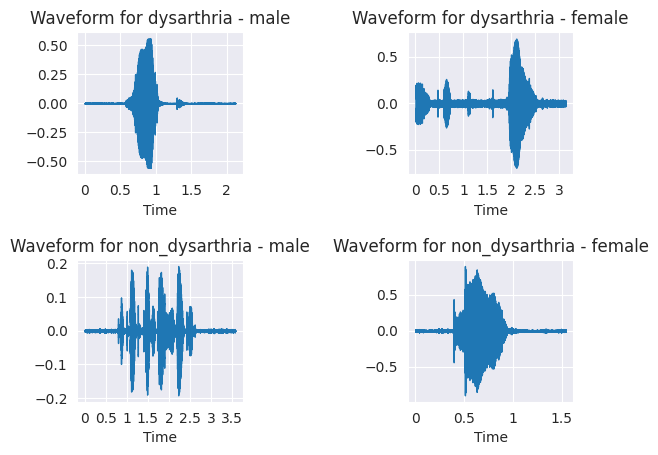

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

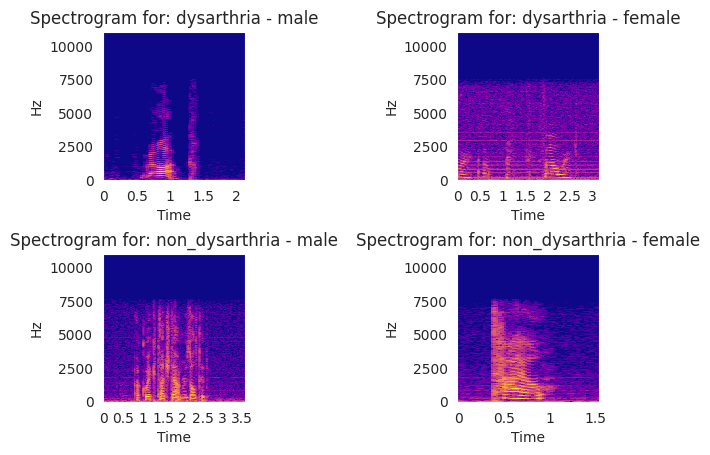

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

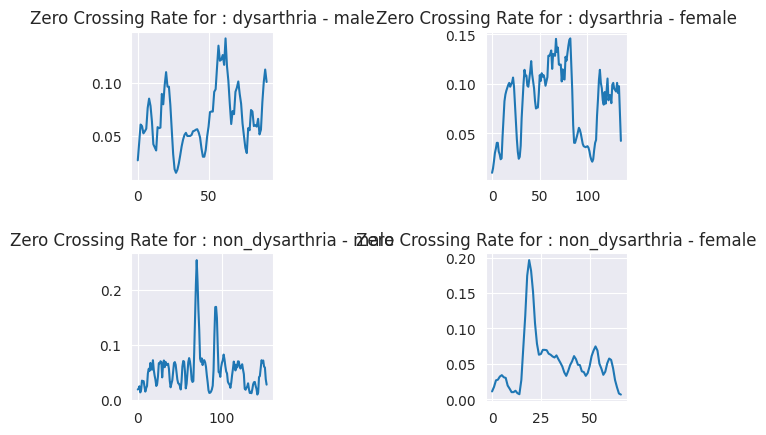

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

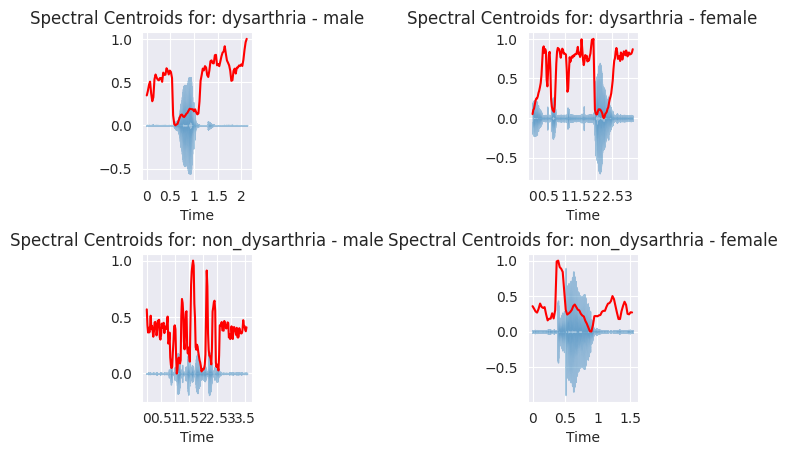

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

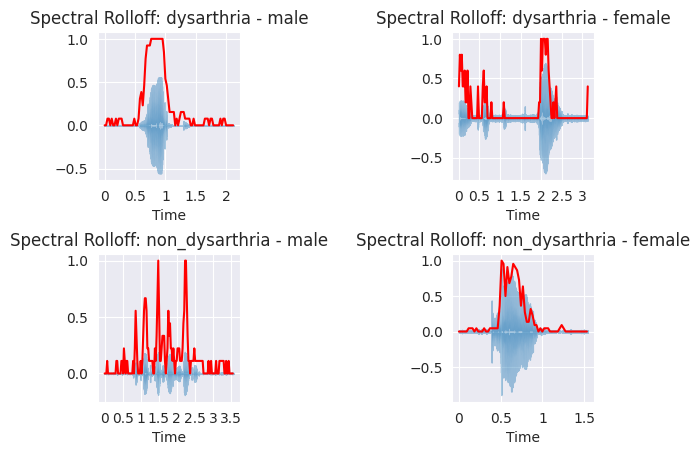

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

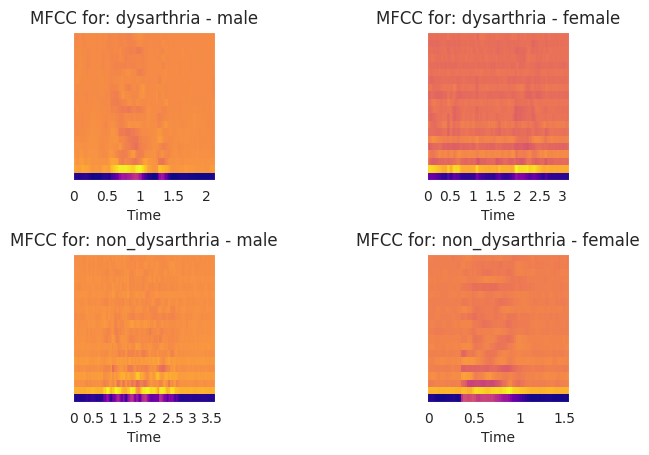

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

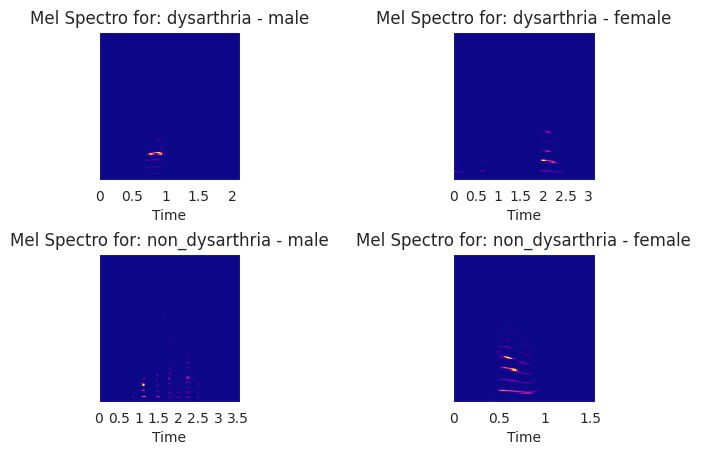

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

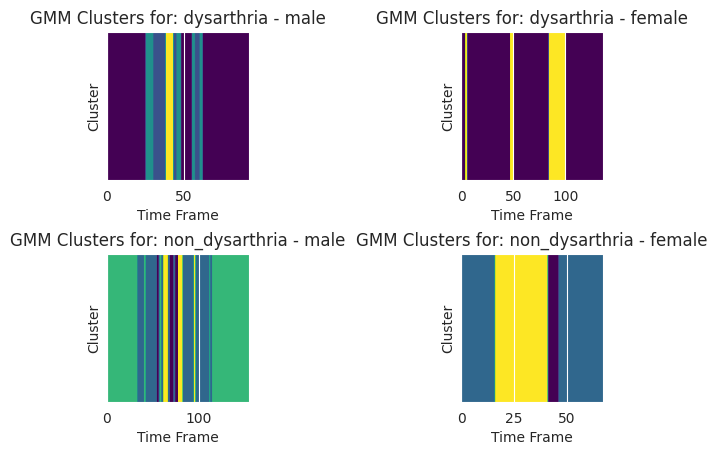

In [ ]:
show_waveplot(audio_path, label, gender)
show_spectrogram(audio_path, label, gender)
show_zcr(audio_path, label, gender)
show_spectral_centroids(audio_path, label, gender)
show_spectral_rolloff(audio_path, label, gender)
show_mfccs(audio_path, label, gender)
show_melspectro(audio_path,label,gender)

gmm_model = fit_gmm(audio_path, n_components=5)

plot_gmm_clusters(gmm_model,audio_path, label, gender)

# ***Splitting train and test audios***

In [6]:
tdysarthria_male = data[(data['gender'] == 'male') & (data['is_dysarthria'] == 'dysarthria')].sample(50)
tdysarthria_female = data[(data['gender'] == 'female') & (data['is_dysarthria'] == 'dysarthria')].sample(50)
tnon_dysarthria_male = data[(data['gender'] == 'male') & (data['is_dysarthria'] == 'non_dysarthria')].sample(50)
tnon_dysarthria_female = data[(data['gender'] == 'female') & (data['is_dysarthria'] == 'non_dysarthria')].sample(50)

test_data = pd.concat([tdysarthria_male, tdysarthria_female, tnon_dysarthria_male, tnon_dysarthria_female], ignore_index=True)

train_data = data.drop(test_data.index)
train_data.reset_index(drop=True, inplace=True)

train_data

,is_dysarthria,gender,filename
0,non_dysarthria,female,/content/torgo_data/non_dysarthria_female/FC02...
1,non_dysarthria,female,/content/torgo_data/non_dysarthria_female/FC03...
2,non_dysarthria,female,/content/torgo_data/non_dysarthria_female/FC03...
3,non_dysarthria,female,/content/torgo_data/non_dysarthria_female/FC02...
4,non_dysarthria,female,/content/torgo_data/non_dysarthria_female/FC03...
...,...,...,...
1795,dysarthria,male,/content/torgo_data/dysarthria_male/M03_Sessio...
1796,dysarthria,male,/content/torgo_data/dysarthria_male/M02_Sessio...
1797,dysarthria,male,/content/torgo_data/dysarthria_male/M03_Sessio...
1798,dysarthria,male,/content/torgo_data/dysarthria_male/M03_Sessio...


In [7]:
overlapping_rows = test_data[test_data.isin(train_data)].dropna()
if len(overlapping_rows) == 0:
    print("test_data and train_data have distinct samples.")
else:
    print("Overlapping samples found between test_data and train_data:")
    print(overlapping_rows)

test_data and train_data have distinct samples.


# ***Feature Extraction***

In [8]:
def feature_extraction(df):
    mfcc_features = []
    zcr_features = []
    spectral_bandwidth_features = []
    spectral_centroid_features = []
    spectral_contrast_features =[]
    spectral_flatness_features = []
    spectral_rolloff_features = []
    for i,record in tqdm(df.iterrows(),total=df.shape[0]):
        try:
            x , sr = librosa.load(record['filename'])
            mean_mfcc = np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128),axis=1)
            mfcc_features.append(mean_mfcc)
            '''mean_zcr = np.mean(librosa.feature.zero_crossing_rate(y=x),axis=1)
            zcr_features.append(mean_zcr)
            mean_sb = np.mean(librosa.feature.spectral_bandwidth(y=x, sr=sr),axis=1)
            spectral_bandwidth_features.append(mean_sb)
            mean_sce = np.mean(librosa.feature.spectral_centroid(y=x, sr=sr),axis=1)
            spectral_centroid_features.append(mean_sce)
            mean_sco = np.mean(librosa.feature.spectral_contrast(y=x, sr=sr),axis=1)
            spectral_contrast_features.append(mean_sco)
            mean_sf = np.mean(librosa.feature.spectral_flatness(y=x),axis=1)
            spectral_flatness_features.append(mean_sf)
            mean_sr = np.mean(librosa.feature.spectral_rolloff(y=x, sr=sr),axis=1)
            spectral_rolloff_features.append(mean_sr)'''
        except EOFError:
            pass

    mfcc_dataf = pd.DataFrame(mfcc_features)
    mfcc_dataf['class'] = df['is_dysarthria']
    '''
    zcr_dataf = pd.DataFrame(zcr_features)
    sb_dataf = pd.DataFrame(spectral_bandwidth_features)
    sce_dataf = pd.DataFrame(spectral_centroid_features)
    sco_dataf = pd.DataFrame(spectral_contrast_features)
    sf_dataf = pd.DataFrame(spectral_flatness_features)
    sr_dataf = pd.DataFrame(spectral_rolloff_features)
    zcr_dataf['class'] = df['is_dysarthria']
    sb_dataf['class'] = df['is_dysarthria']
    sce_dataf['class'] = df['is_dysarthria']
    sco_dataf['class'] = df['is_dysarthria']
    sf_dataf['class'] = df['is_dysarthria']
    sr_dataf['class'] = df['is_dysarthria']
    '''
    return (mfcc_dataf) #, zcr_dataf, sb_dataf, sce_dataf, sco_dataf, sf_dataf, sr_dataf)

In [9]:
mfcc_dataf = feature_extraction(train_data)

100%|██████████| 1800/1800 [01:01<00:00, 29.19it/s]


In [10]:
test_dataf = feature_extraction(test_data)

100%|██████████| 200/200 [00:06<00:00, 30.41it/s]


In [11]:
X = []
y = []
for i in [mfcc_dataf, test_dataf]: #, zcr_dataf, sb_dataf, sce_dataf, sco_dataf, sf_dataf, sr_dataf, test_dataf]:
  i.loc[i['class']=='non_dysarthria','class'] = 0.0
  i.loc[i['class']=='dysarthria','class'] = 1.0
  i['class'] = i['class'].astype(float)

  X.append(i.iloc[:,:-1].values)
  y.append(i.iloc[:,-1])

#mfcc_X, zcr_X, sb_X, sce_X, sco_X, sf_X, sr_X, test_X = X
#mfcc_y, zcr_y, sb_y, sce_y, sco_y, sf_y, sr_y, test_y = y
mfcc_X, test_X= X
mfcc_y, test_y = y

# ***Splitting training and validation data***

In [12]:
mfcc_X_train, mfcc_X_test, mfcc_y_train, mfcc_y_test = train_test_split(mfcc_X, mfcc_y, test_size=0.1, stratify=mfcc_y)
'''
zcr_X_train, zcr_X_test, zcr_y_train, zcr_y_test = train_test_split(zcr_X, zcr_y, test_size=0.2, stratify=zcr_y)
sb_X_train, sb_X_test, sb_y_train, sb_y_test = train_test_split(sb_X, sb_y, test_size=0.2, stratify=sb_y)
sce_X_train, sce_X_test, sce_y_train, sce_y_test = train_test_split(sce_X, sce_y, test_size=0.2, stratify=sce_y)
sco_X_train, sco_X_test, sco_y_train, sco_y_test = train_test_split(sco_X, sco_y, test_size=0.2, stratify=sco_y)
sf_X_train, sf_X_test, sf_y_train, sf_y_test = train_test_split(sf_X, sf_y, test_size=0.2, stratify=sf_y)
sr_X_train, sr_X_test, sr_y_train, sr_y_test = train_test_split(sr_X, sr_y, test_size=0.2, stratify=sr_y)
'''
mfcc_X_train_shape = mfcc_X_train
mfcc_X_test_shape = mfcc_X_test
mfcc_X_train = mfcc_X_train.reshape(-1,16,8,1)
mfcc_X_test = mfcc_X_test.reshape(-1,16,8,1)
test_X = test_X.reshape(-1,16,8,1)

In [31]:
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import ModelCheckpoint, EarlyStopping

def k_fold_val(build, name):
  num_folds = 10
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

  all_history = []

  for fold_num, (train_index, test_index) in enumerate(kfold.split(mfcc_X, mfcc_y)):
    print(f"Training on fold {fold_num + 1}/{num_folds}")

    X_train, X_test = mfcc_X[train_index], mfcc_X[test_index]
    y_train, y_test = mfcc_y[train_index], mfcc_y[test_index]

    X_train = X_train.reshape(-1, 16, 8, 1)
    X_test = X_test.reshape(-1, 16, 8, 1)


    model = build()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(f'{name}_{fold_num + 1}.h5', save_best_only=True)
    earlystopping = EarlyStopping(patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[checkpoint, earlystopping])

    all_history.append(history)

  return all_history


In [24]:
def acc_loss(all_history):
  train_accuracies = []
  val_accuracies = []
  losses = []
  val_losses = []
  for history in all_history:
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    train_accuracies.append(train_acc[-1])
    val_accuracies.append(val_acc[-1])
    losses.append(loss[-1])
    val_losses.append(val_loss[-1])

  mean_train_accuracy = sum(train_accuracies) / len(train_accuracies)
  mean_val_accuracy = sum(val_accuracies) / len(val_accuracies)
  mean_loss = sum(losses) / len(losses)
  mean_val_loss = sum(val_losses) / len(val_losses)

  print(f"Mean Training Accuracy: {mean_train_accuracy}")
  print(f"Mean Validation Accuracy: {mean_val_accuracy}")
  print(f"Mean Loss: {mean_loss}")
  print(f"Mean Validation Loss: {mean_val_loss}")

  return (train_accuracies, val_accuracies, losses, val_losses)

In [33]:
def plot_losses(losses, val_losses):
  plt.figure(figsize=(20,8))
  plt.plot(losses)
  plt.plot(val_losses)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [26]:
def plot_accuracies(train_accuracies, val_accuracies):
  plt.figure(figsize=(20,8))
  plt.plot(train_accuracies)
  plt.plot(val_accuracies)
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [27]:
def plot_test(label, test_y,  y_pred):
  plt.figure(figsize=(20,8))
  fpr, tpr, _ = roc_curve(test_y,  y_pred)
  auc = roc_auc_score(test_y, y_pred)
  plt.plot(fpr,tpr,label=f"{label}, auc="+str(auc),lw=2)
  plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
  plt.legend(loc=4)
  plt.show()

In [28]:
def heat_map(test_y, y_pred):
  sns.heatmap(confusion_matrix(test_y, y_pred),cmap='viridis',annot=True,fmt='.3g',
            xticklabels=['Non Dysarthria','Dysarthria'],yticklabels=['Non Dysarthria','Dysarthria'])
  plt.xlabel('Predicted Class')
  plt.ylabel('Actual Class')
  plt.show()

# ***CNN model with MFCC***

In [29]:
def build_model():
  model = Sequential([
    InputLayer(input_shape=(16, 8, 1)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = "same"),
    MaxPooling2D(2, 2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = "same"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
  ])
  model.summary()
  return model

In [32]:
cnn_history = k_fold_val(build_model, "CNN_model")

Training on fold 1/10
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 16, 8, 32)         320       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 8, 4, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 8, 4, 64)          18496     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 4, 2, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_26 (Flatten)        (None, 512)               0         
                                                                 
 dense_30 (Dense)            (No

In [34]:
(train_accuracies, val_accuracies, losses, val_losses) = acc_loss(cnn_history)

Mean Training Accuracy: 0.9917855560779572
Mean Validation Accuracy: 0.9849875807762146
Mean Loss: 0.04161321297287941
Mean Validation Loss: 0.0595810204744339


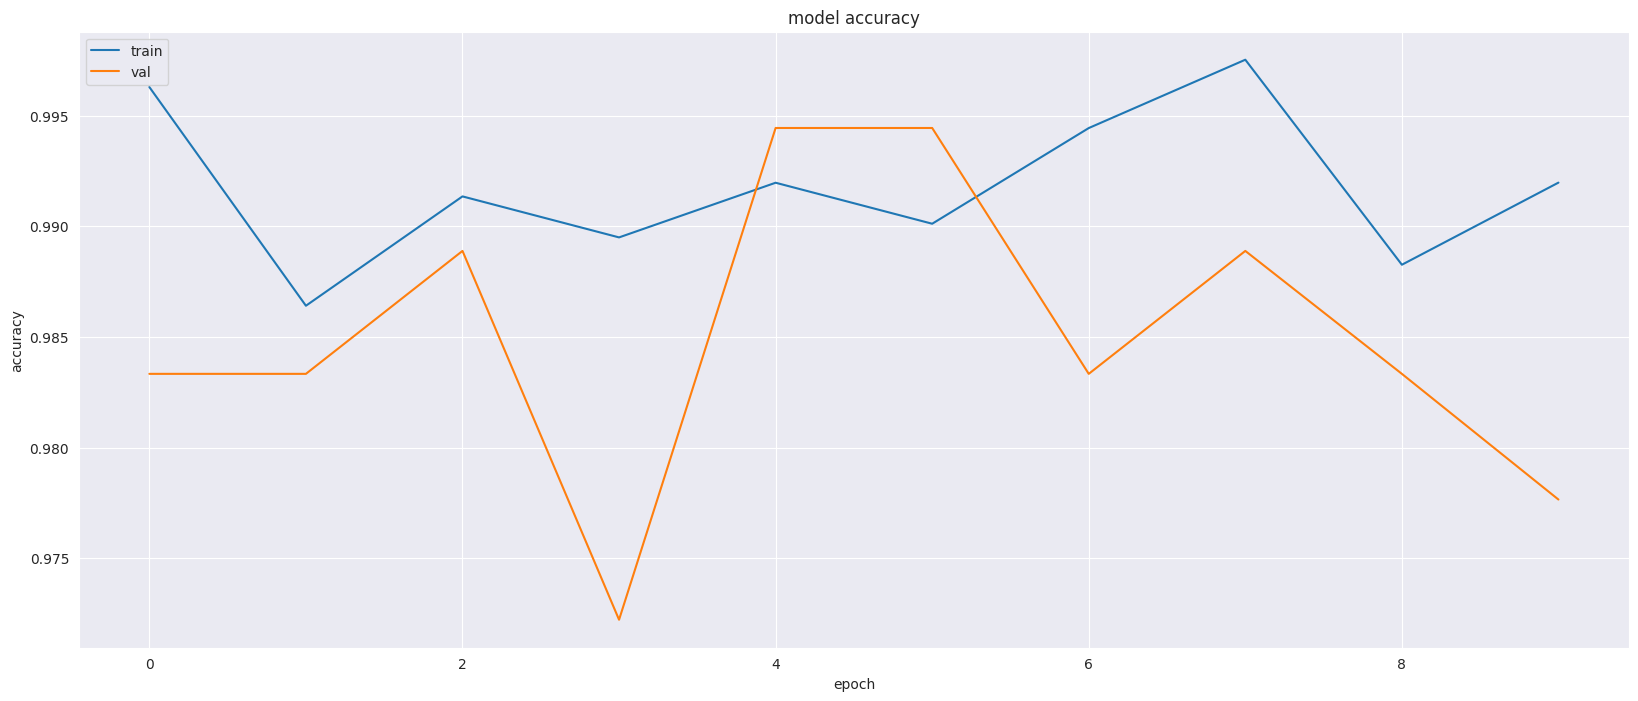

In [35]:
plot_accuracies(train_accuracies, val_accuracies)

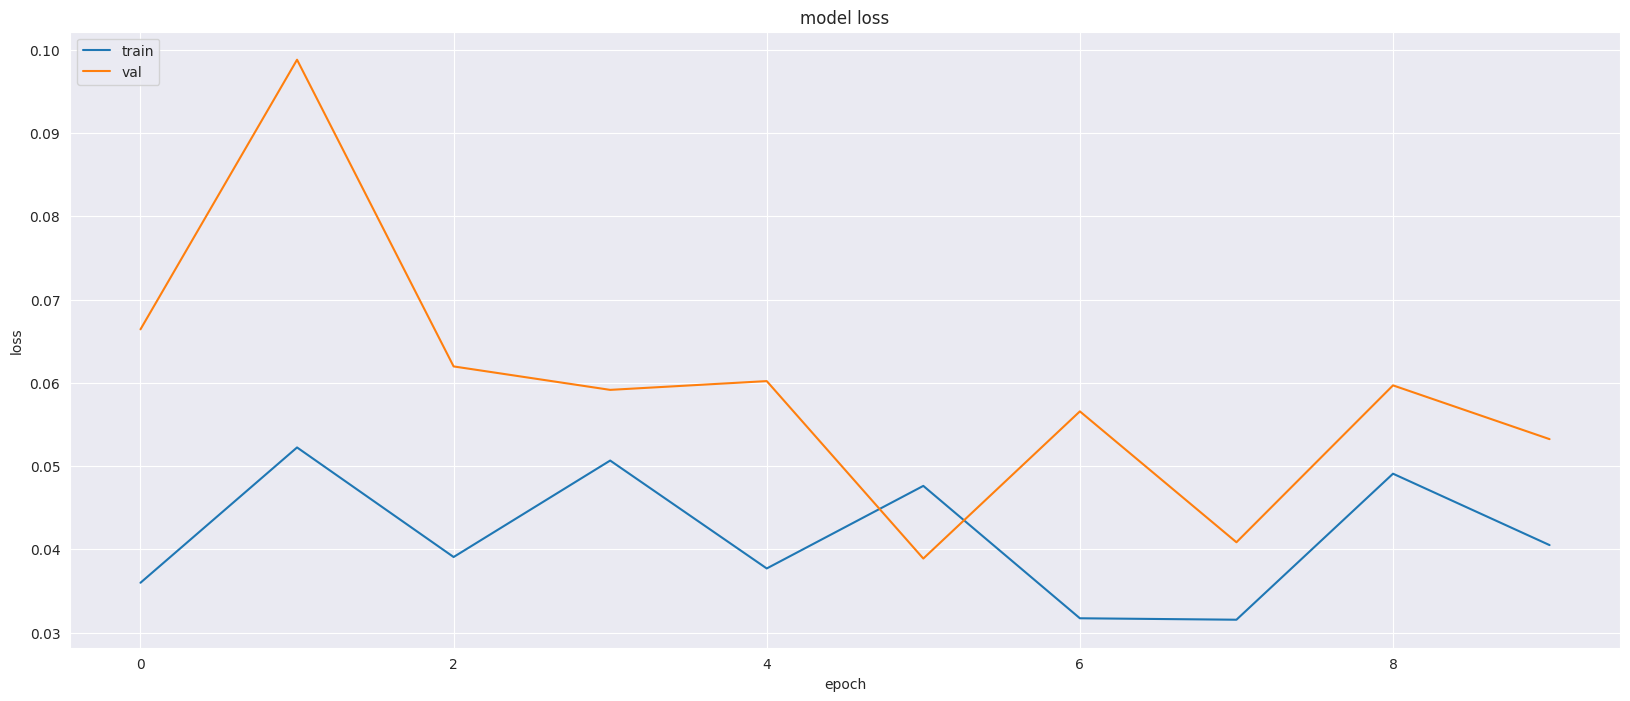

In [36]:
plot_losses(losses, val_losses)

In [37]:
loaded_cnn_model = tf.keras.models.load_model("/content/CNN_model_1.h5")
cnn_y_pred = loaded_cnn_model.predict(test_X)

7/7 [==============================] - 0s 7ms/step


In [38]:
cnn_y_pred[cnn_y_pred>=0.5] = 1
cnn_y_pred[cnn_y_pred<0.5] = 0

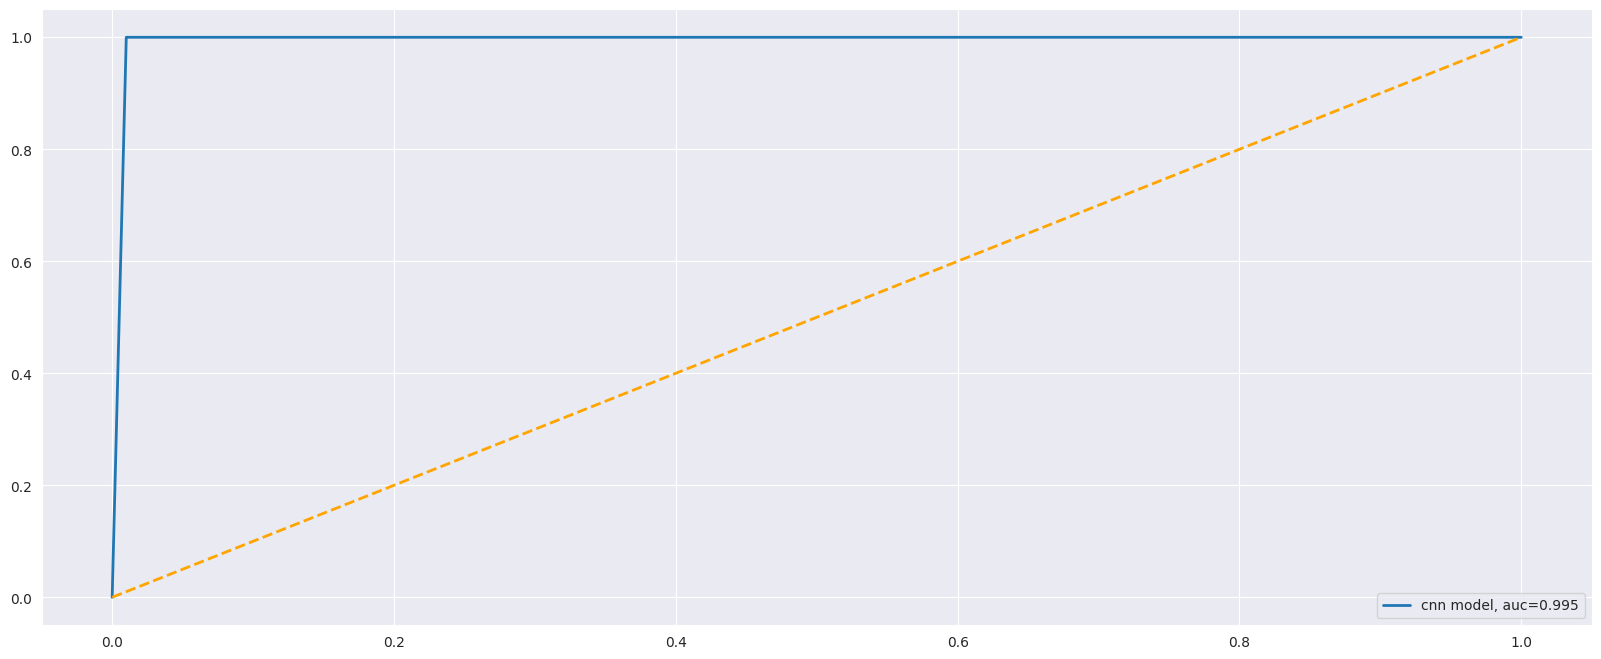

In [55]:
plot_test("cnn model", test_y,  cnn_y_pred)

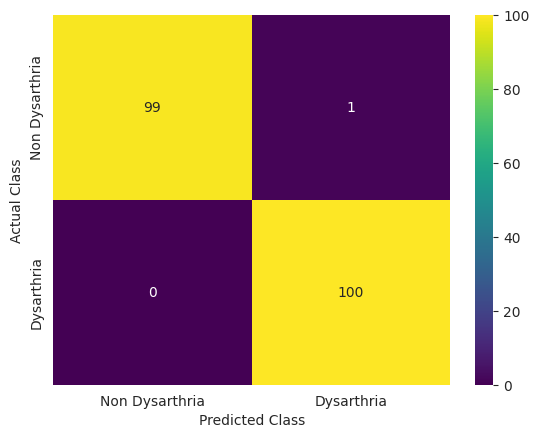

In [39]:
heat_map(test_y, cnn_y_pred)

In [40]:
print(classification_report(test_y,cnn_y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       100
         1.0       0.99      1.00      1.00       100

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



In [41]:
print("Recall Score of the Model: ",recall_score(test_y,cnn_y_pred))

Recall Score of the Model:  1.0


# ***Logistic Regression***

In [ ]:
from sklearn.linear_model import *
from sklearn.metrics import accuracy_score
from joblib import dump, load

labels = extract_labels(audio_path)

print(len(labels))

GMM_model = LogisticRegression()

checkpoint = ModelCheckpoint(f'gmm_model.h5', save_best_only=True)
earlystopping = EarlyStopping(patience=3, restore_best_weights=True)

GMM_model.fit(mfcc_X_train_shape, mfcc_y_train)

dump(GMM_model, 'logistic_regression_model.joblib')

GMM_y_pred = GMM_model.predict(mfcc_X_test_shape)

accuracy = accuracy_score(mfcc_y_test, GMM_y_pred)
print(f"Model Accuracy: {accuracy}")


4
Model Accuracy: 0.9222222222222223


In [ ]:
loaded_model = load('logistic_regression_model.joblib')

# ***Transformer***

In [48]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, MultiHeadAttention, LayerNormalization
from tensorflow.keras.models import Model

class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.layer_norm = LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        attention_output = self.multi_head_attention(inputs, inputs, inputs)
        attention_output = self.layer_norm(inputs + attention_output)
        return attention_output

def build_transformer_model():
    input_layer = Input(shape=(16, 8, 1))
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding="same")(input_layer)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding="same")(x)
    x = MaxPooling2D(2, 2)(x)

    # Transformer block
    transformer_encoder = TransformerEncoder(num_heads=2, key_dim=64)(x)

    x = Flatten()(x)
    transformer_encoder = Flatten()(transformer_encoder)

    concatenated_output = tf.keras.layers.concatenate([x, transformer_encoder])

    dense_layer = Dense(32, activation='relu')(concatenated_output)
    output_layer = Dense(1, activation='sigmoid')(dense_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.summary()

    return model

In [43]:
trans_history = k_fold_val(build_transformer_model, "trans_model")

Training on fold 1/10
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 16, 8, 1)]           0         []                            
                                                                                                  
 conv2d_48 (Conv2D)          (None, 16, 8, 32)            320       ['input_27[0][0]']            
                                                                                                  
 max_pooling2d_48 (MaxPooli  (None, 8, 4, 32)             0         ['conv2d_48[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_49 (Conv2D)          (None, 8, 4, 64)             18496     [

In [44]:
(train_accuracies, val_accuracies, losses, val_losses) = acc_loss(trans_history)

Mean Training Accuracy: 0.9959853649139404
Mean Validation Accuracy: 0.9805462419986725
Mean Loss: 0.016685498761944473
Mean Validation Loss: 0.0537437554448843


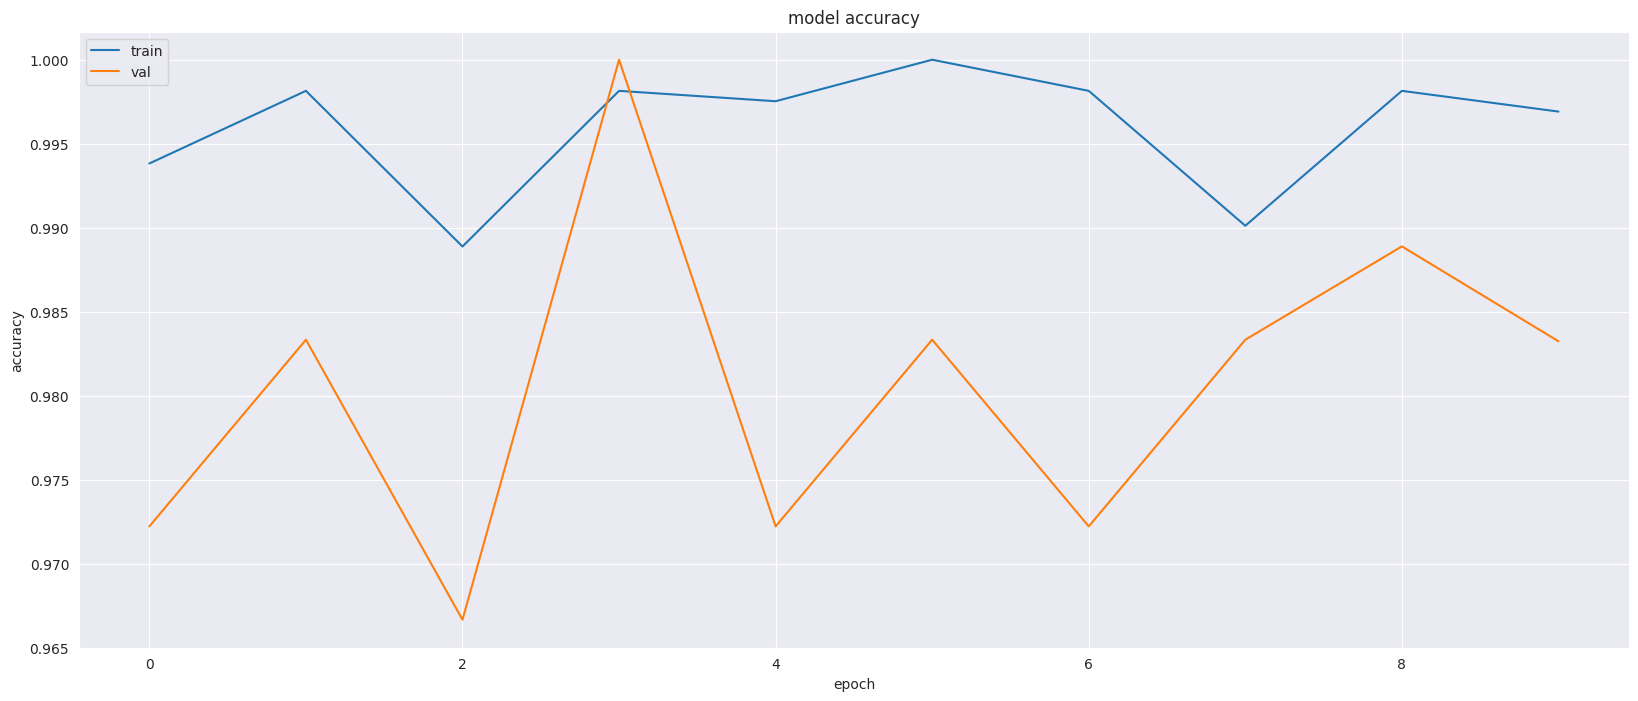

In [45]:
plot_accuracies(train_accuracies, val_accuracies)

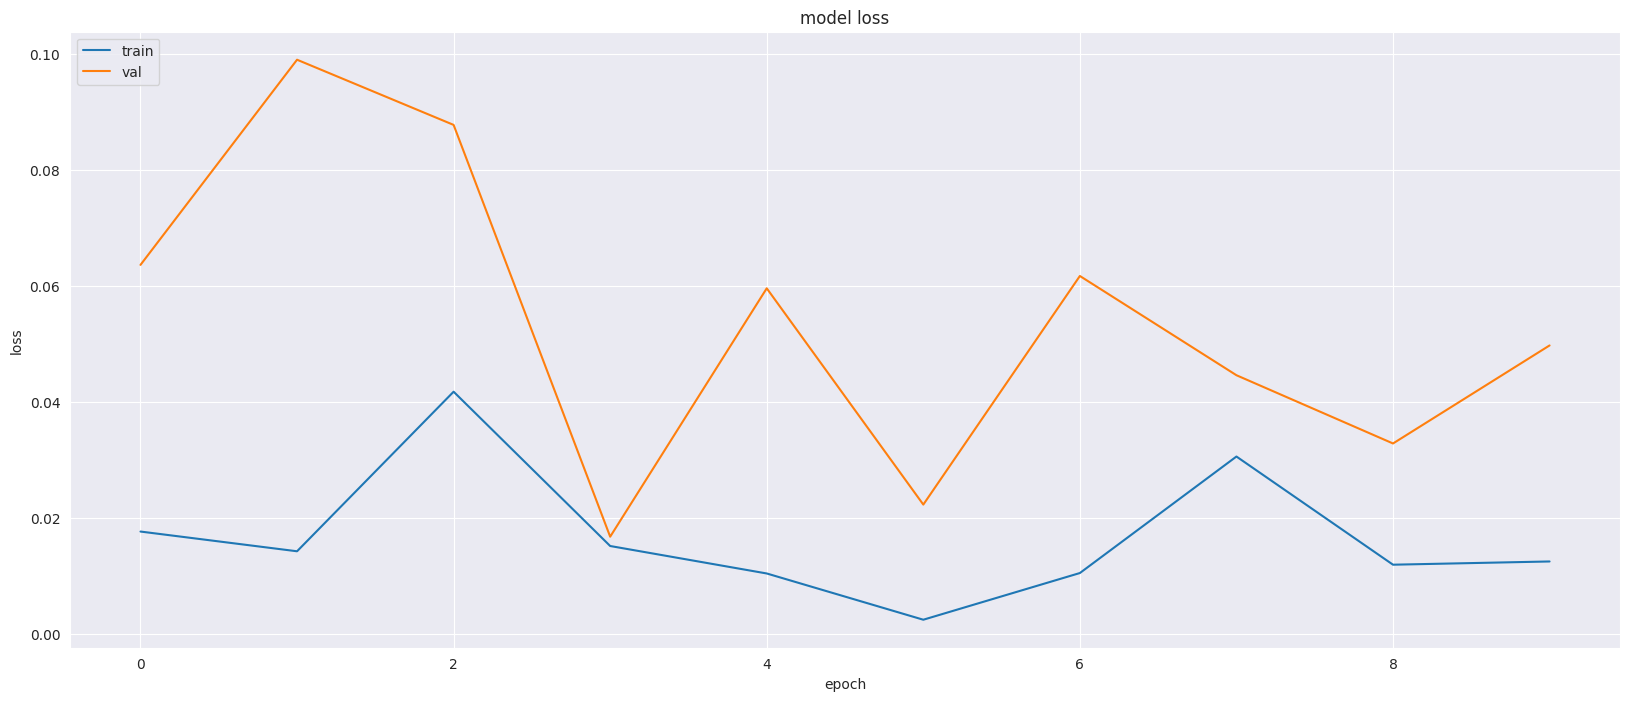

In [46]:
plot_losses(losses, val_losses)

In [50]:
custom_objects = {'TransformerEncoder': TransformerEncoder}
loaded_trans_model = tf.keras.models.load_model("/content/trans_model_1.h5", custom_objects=custom_objects)

trans_y_pred = loaded_trans_model.predict(test_X)

7/7 [==============================] - 1s 22ms/step


In [51]:
trans_y_pred[trans_y_pred>=0.5] = 1
trans_y_pred[trans_y_pred<0.5] = 0

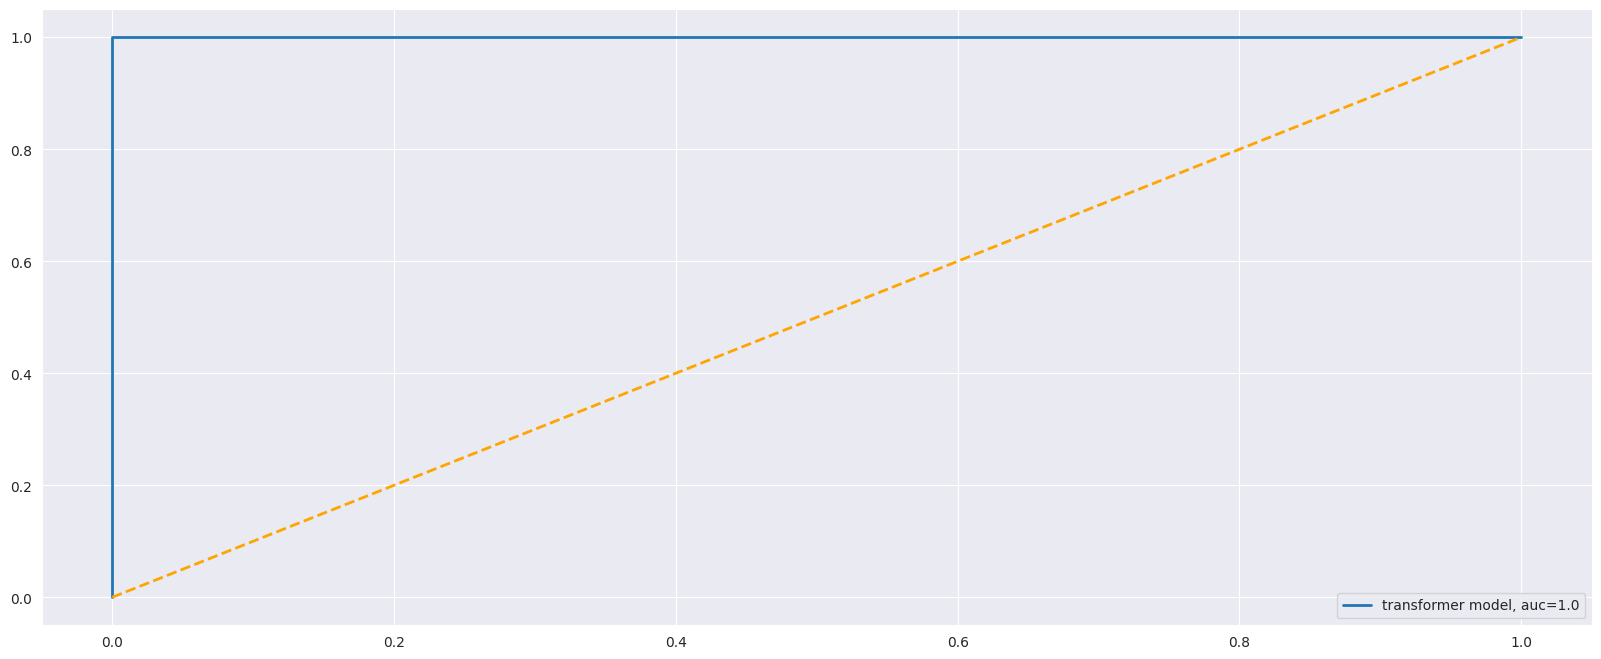

In [56]:
plot_test("transformer model", test_y, trans_y_pred)

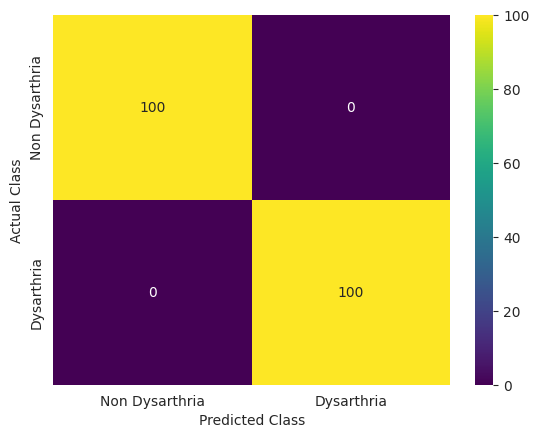

In [52]:
heat_map(test_y, trans_y_pred)

In [53]:
print(classification_report(test_y,trans_y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       100
         1.0       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [54]:
print("Recall Score of the Model: ",recall_score(test_y,cnn_y_pred))

Recall Score of the Model:  1.0


# ***Trying through Zero crossing Rate***

In [ ]:
from tensorflow.keras import regularizers
model_2 = keras.Sequential([
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

In [ ]:
model_2.compile(optimizer="rmsprop",
      loss="binary_crossentropy",
      metrics=["accuracy"])

In [ ]:
zcr_model_name = "zcr_model.h5"
zcr_checkpoint = ModelCheckpoint(zcr_model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

zcr_earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

In [ ]:
model_2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 128)               256       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_29 (Dense)            (None, 1)               

In [ ]:
history_zcr = model_2.fit(zcr_X_train,
            zcr_y_train,
            epochs=20,
            batch_size=128,
            validation_data=(zcr_X_test, zcr_y_test),
            callbacks=[zcr_checkpoint,zcr_earlystopping])

Epoch 1/20
 1/13 [=>............................] - ETA: 0s - loss: 0.7049 - accuracy: 0.4609
Epoch 1: val_loss improved from inf to 0.68701, saving model to zcr_model.h5
13/13 [==============================] - 0s 11ms/step - loss: 0.6874 - accuracy: 0.5553 - val_loss: 0.6870 - val_accuracy: 0.5556
Epoch 2/20
 1/13 [=>............................] - ETA: 0s - loss: 0.7029 - accuracy: 0.4844
Epoch 2: val_loss improved from 0.68701 to 0.68701, saving model to zcr_model.h5
13/13 [==============================] - 0s 8ms/step - loss: 0.6871 - accuracy: 0.5553 - val_loss: 0.6870 - val_accuracy: 0.5556
Epoch 3/20
 1/13 [=>............................] - ETA: 0s - loss: 0.6836 - accuracy: 0.5703
Epoch 3: val_loss improved from 0.68701 to 0.68700, saving model to zcr_model.h5
13/13 [==============================] - 0s 8ms/step - loss: 0.6870 - accuracy: 0.5553 - val_loss: 0.6870 - val_accuracy: 0.5556
Epoch 4/20
 1/13 [=>............................] - ETA: 0s - loss: 0.6901 - accuracy: 0.53

In [ ]:
y_pred_zcr = model_2.predict(test_X)

7/7 [==============================] - 0s 14ms/step


# ***Trying through Spectral Bandwidth***

In [ ]:
sb_model_name = "sb_model.h5"
sb_checkpoint = ModelCheckpoint(sb_model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

sb_earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

In [ ]:
history_sb = model_2.fit(sb_X_train,
            sb_y_train,
            epochs=30,
            batch_size=128,
            validation_data=(sb_X_test, sb_y_test),
            callbacks=[sb_checkpoint,sb_earlystopping])

Epoch 1/30
 1/13 [=>............................] - ETA: 0s - loss: 0.6800 - accuracy: 0.5859
Epoch 1: val_loss improved from inf to 0.68657, saving model to sb_model.h5
13/13 [==============================] - 0s 12ms/step - loss: 0.6877 - accuracy: 0.5553 - val_loss: 0.6866 - val_accuracy: 0.5556
Epoch 2/30
 1/13 [=>............................] - ETA: 0s - loss: 0.6866 - accuracy: 0.5547
Epoch 2: val_loss did not improve from 0.68657
13/13 [==============================] - 0s 5ms/step - loss: 0.6876 - accuracy: 0.5553 - val_loss: 0.6868 - val_accuracy: 0.5556
Epoch 3/30
 1/13 [=>............................] - ETA: 0s - loss: 0.6827 - accuracy: 0.5781
Epoch 3: val_loss did not improve from 0.68657
13/13 [==============================] - 0s 6ms/step - loss: 0.6874 - accuracy: 0.5553 - val_loss: 0.6868 - val_accuracy: 0.5556
Epoch 4/30
 1/13 [=>............................] - ETA: 0s - loss: 0.6670 - accuracy: 0.6484
Epoch 4: val_loss did not improve from 0.68657
13/13 [============

# ***Trying through Spectral Centroid***

In [ ]:
sce_model_name = "sce_model.h5"
sce_checkpoint = ModelCheckpoint(sce_model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

sce_earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

In [ ]:
history_sce = model_2.fit(sce_X_train,
            sce_y_train,
            epochs=20,
            batch_size=128,
            validation_data=(sce_X_test, sce_y_test),
            callbacks=[sce_checkpoint,sce_earlystopping])

Epoch 1/20
12/13 [==========================>...] - ETA: 0s - loss: 0.6875 - accuracy: 0.5540
Epoch 1: val_loss improved from inf to 0.68638, saving model to sce_model.h5
13/13 [==============================] - 0s 21ms/step - loss: 0.6873 - accuracy: 0.5553 - val_loss: 0.6864 - val_accuracy: 0.5556
Epoch 2/20
12/13 [==========================>...] - ETA: 0s - loss: 0.6863 - accuracy: 0.5560
Epoch 2: val_loss did not improve from 0.68638
13/13 [==============================] - 0s 11ms/step - loss: 0.6865 - accuracy: 0.5553 - val_loss: 0.6864 - val_accuracy: 0.5556
Epoch 3/20
10/13 [======================>.......] - ETA: 0s - loss: 0.6857 - accuracy: 0.5594
Epoch 3: val_loss improved from 0.68638 to 0.68552, saving model to sce_model.h5
13/13 [==============================] - 0s 11ms/step - loss: 0.6866 - accuracy: 0.5553 - val_loss: 0.6855 - val_accuracy: 0.5556
Epoch 4/20
13/13 [==============================] - ETA: 0s - loss: 0.6860 - accuracy: 0.5553
Epoch 4: val_loss improved fr

# ***Trying through Spectral Flatness***

In [ ]:
sf_model_name = "sf_model.h5"
sf_checkpoint = ModelCheckpoint(sf_model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

sf_earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

In [ ]:
history_sf = model_2.fit(sf_X_train,
            sf_y_train,
            epochs=20,
            batch_size=128,
            validation_data=(sf_X_test, sf_y_test),
            callbacks=[sf_checkpoint,sf_earlystopping])

Epoch 1/20
 1/13 [=>............................] - ETA: 0s - loss: 0.7039 - accuracy: 0.5078
Epoch 1: val_loss improved from inf to 0.68726, saving model to sf_model.h5
13/13 [==============================] - 0s 13ms/step - loss: 0.6879 - accuracy: 0.5553 - val_loss: 0.6873 - val_accuracy: 0.5556
Epoch 2/20
 1/13 [=>............................] - ETA: 0s - loss: 0.6926 - accuracy: 0.5391
Epoch 2: val_loss improved from 0.68726 to 0.68707, saving model to sf_model.h5
13/13 [==============================] - 0s 8ms/step - loss: 0.6882 - accuracy: 0.5553 - val_loss: 0.6871 - val_accuracy: 0.5556
Epoch 3/20
 1/13 [=>............................] - ETA: 0s - loss: 0.6939 - accuracy: 0.5312
Epoch 3: val_loss improved from 0.68707 to 0.68702, saving model to sf_model.h5
13/13 [==============================] - 0s 8ms/step - loss: 0.6879 - accuracy: 0.5553 - val_loss: 0.6870 - val_accuracy: 0.5556
Epoch 4/20
 1/13 [=>............................] - ETA: 0s - loss: 0.6763 - accuracy: 0.6016


# ***Trying through Spectral Rolloff***

In [ ]:
sr_model_name = "sr_model.h5"
sr_checkpoint = ModelCheckpoint(sr_model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

sr_earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

In [ ]:
history_sr = model_2.fit(sr_X_train,
            sr_y_train,
            epochs=20,
            batch_size=128,
            validation_data=(sr_X_test, sr_y_test),
            callbacks=[sr_checkpoint,sr_earlystopping])

Epoch 1/20
 1/13 [=>............................] - ETA: 0s - loss: 0.6979 - accuracy: 0.5078
Epoch 1: val_loss improved from inf to 0.68584, saving model to sr_model.h5
13/13 [==============================] - 0s 13ms/step - loss: 0.6880 - accuracy: 0.5553 - val_loss: 0.6858 - val_accuracy: 0.5556
Epoch 2/20
 1/13 [=>............................] - ETA: 0s - loss: 0.7121 - accuracy: 0.4141
Epoch 2: val_loss did not improve from 0.68584
13/13 [==============================] - 0s 6ms/step - loss: 0.6866 - accuracy: 0.5553 - val_loss: 0.6860 - val_accuracy: 0.5556
Epoch 3/20
 1/13 [=>............................] - ETA: 0s - loss: 0.6792 - accuracy: 0.5938
Epoch 3: val_loss improved from 0.68584 to 0.68520, saving model to sr_model.h5
13/13 [==============================] - 0s 7ms/step - loss: 0.6862 - accuracy: 0.5553 - val_loss: 0.6852 - val_accuracy: 0.5556
Epoch 4/20
 1/13 [=>............................] - ETA: 0s - loss: 0.6856 - accuracy: 0.5547
Epoch 4: val_loss did not improve